In [10]:
import numpy as np
import pandas as pd

#Visualisation Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from pandas.plotting import scatter_matrix

#Training and Preprocessing Libraries
from xgboost import XGBClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [11]:
class_names = ['Fatal', 'Severe', 'Slight']

In [21]:
data1 = pd.read_csv("C:/Users/P Naresh Reddy/Downloads/1-6m-accidents-traffic-flow-over-16-years/accidents_2005_to_2007.csv")
data2 = pd.read_csv("C:/Users/P Naresh Reddy/Downloads/1-6m-accidents-traffic-flow-over-16-years/accidents_2009_to_2011.csv")
data3 = pd.read_csv("C:/Users/P Naresh Reddy/Downloads/1-6m-accidents-traffic-flow-over-16-years/accidents_2012_to_2014.csv")

In [22]:
data = pd.concat([data1, data2, data3])

In [23]:
def max_val(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

year_wise_casualties = data.groupby(['Year'])['Number_of_Casualties'].sum()
year_wise_casualties = year_wise_casualties.reset_index()
year_wise_casualties = year_wise_casualties.style.apply(max_val, axis=0)
year_wise_casualties

,Year,Number_of_Casualties
0,2005,271017
1,2006,258404
2,2007,247780
3,2009,222146
4,2010,208648
5,2011,203950
6,2012,241954
7,2013,183670
8,2014,194477


In [24]:
cas_table = data.groupby(['Day_of_Week']).agg({'Number_of_Casualties':['sum'],'Speed_limit':['min','max']})
cas_table = cas_table.sort_values([('Number_of_Casualties','sum')],ascending=False)
cas_table = cas_table.reset_index()
cas_table.style.apply(max_val)

In [25]:
corr_matrix = data.corr()
corr_matrix["Accident_Severity"].sort_values(ascending=False)

Accident_Severity             1.000000
Number_of_Vehicles            0.075976
2nd_Road_Class                0.064321
2nd_Road_Number               0.026128
Longitude                     0.013946
Location_Easting_OSGR         0.013465
1st_Road_Class                0.012754
Day_of_Week                   0.002961
1st_Road_Number              -0.004072
Year                         -0.005907
Latitude                     -0.031357
Location_Northing_OSGR       -0.031395
Police_Force                 -0.031712
Local_Authority_(District)   -0.031995
Speed_limit                  -0.079108
Urban_or_Rural_Area          -0.082169
Number_of_Casualties         -0.083544
Junction_Detail                    NaN
Name: Accident_Severity, dtype: float64

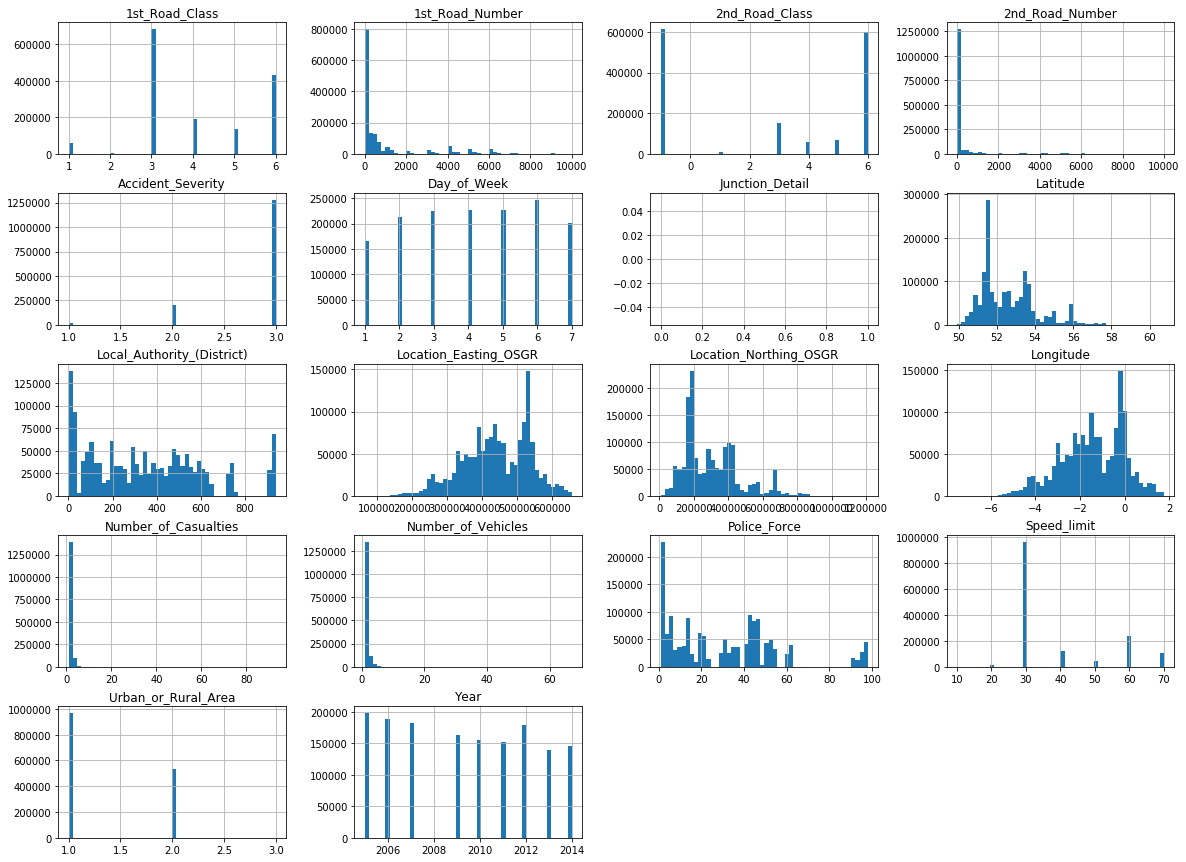

In [26]:
data.hist(bins=50, figsize=(20,15))
plt.show()

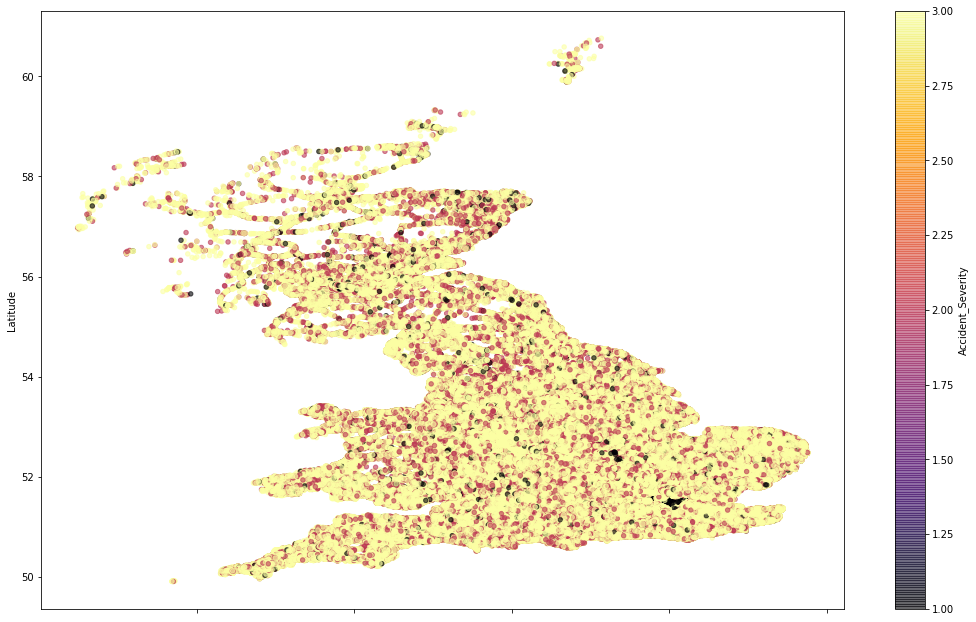

In [27]:
fig = data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.6,
                   figsize=(18,11),c="Accident_Severity", cmap=plt.get_cmap("inferno"), 
                   colorbar=True,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CA038E85C0>,
      dtype=object)

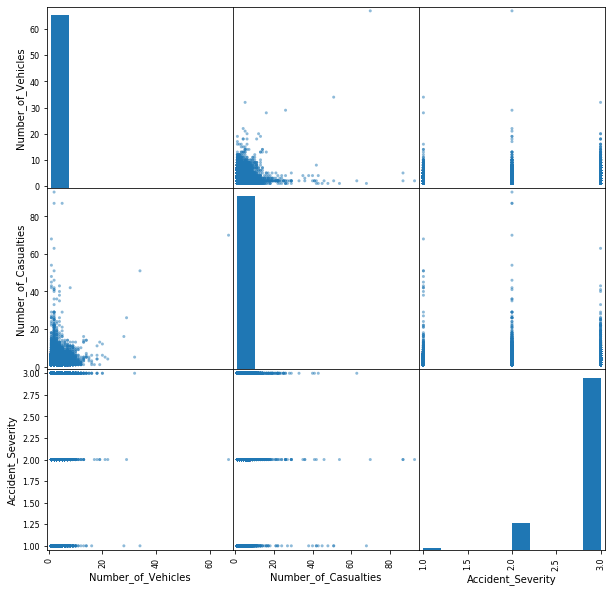

In [28]:
attributes = ["Number_of_Vehicles","Number_of_Casualties", "Time", "Road_Type", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","Accident_Severity"]
scatter_matrix(data[attributes], figsize=(10, 10))

In [29]:
def preprocessing(data):
    #Drop useless columns and nan values
    data.drop(['Police_Force', 'Junction_Detail', 'Junction_Control', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Local_Authority_(District)', 'Local_Authority_(Highway)'], axis=1, inplace=True)
    data.dropna(inplace=True)
    
    #Drop rows with 'Unknown' values
    data = data[data.Weather_Conditions!='Unknown']
    data = data[data.Road_Type!='Unknown']
    
    #Encode "String" Labels into "Int" Labels for easy training
    le = LabelEncoder()
    data["Pedestrian_Crossing-Physical_Facilities"]= le.fit_transform(data["Pedestrian_Crossing-Physical_Facilities"])
    data["Light_Conditions"]= le.fit_transform(data["Light_Conditions"])
    data["Weather_Conditions"] = le.fit_transform(data["Weather_Conditions"])
    data["Road_Surface_Conditions"] = le.fit_transform(data["Road_Surface_Conditions"])
    data["Pedestrian_Crossing-Human_Control"] = le.fit_transform(data["Pedestrian_Crossing-Human_Control"])
    data["Road_Type"] = le.fit_transform(data["Road_Type"])
    
    #Converting Time into Int for easy training
    data["Time"]= data["Time"].astype(str)
    data['Time']=data['Time'].str.slice(0,2, 1)
    data["Time"]= data["Time"].astype(int)
    
    #Creating 3 additional columns, one each for each class we need to classify into
    onehot = pd.get_dummies(data.Accident_Severity,prefix=['Severity'])
    data["Fatal"] = onehot["['Severity']_1"]
    data["Severe"] = onehot["['Severity']_2"]
    data["Slight"] = onehot["['Severity']_3"]
    
    #Finally splitting the data into train and test
    train,test = train_test_split(data,test_size=.25)
    
    return (train,test)

In [30]:
train,test = preprocessing(data)

In [31]:
train_features = train[["Number_of_Vehicles","Number_of_Casualties", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","Year", "Urban_or_Rural_Area"]]
test_features =test[["Number_of_Vehicles","Number_of_Casualties", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","Year", "Urban_or_Rural_Area"]]

In [32]:
def model():
    scores=[]
    acc_score=[]
    submission = pd.DataFrame.from_dict({'Accident_Index': test['Accident_Index']})
    classifier = EasyEnsembleClassifier(n_estimators=12, base_estimator=XGBClassifier(max_depth=4, learning_rate=0.2, n_estimators=600, silent=True,
                        subsample = 0.8,
                        gamma=0.5,
                        min_child_weight=10,
                        objective='binary:logistic',
                        colsample_bytree = 0.6,
                        max_delta_step = 1,
                        nthreads=1,
                        n_jobs=1))
    
    for class_name in class_names:
        train_target = train[class_name]

        cv_score = np.mean(cross_val_score(
            classifier, train_features, train_target, cv=3, scoring='roc_auc'))
        scores.append(cv_score)
        print('CV score for class {} is {}'.format(class_name, cv_score))

        classifier.fit(train_features, train_target)
        
        submission[class_name] = classifier.predict_proba(test_features)[:, 1]
        acc = roc_auc_score(test[class_name],submission[class_name])
        acc_score.append(acc)
        print('Mean accuracy for class {} is {}'.format(class_name,acc))
    
    return (scores,acc_score)
cv, acc = model()

CV score for class Fatal is 0.7849226378511475
Mean accuracy for class Fatal is 0.7923143377880266
CV score for class Severe is 0.6482373413164647
Mean accuracy for class Severe is 0.6493795354671417
CV score for class Slight is 0.6636129386117541
Mean accuracy for class Slight is 0.6649460164432056


In [34]:
print('Total CV score is {}'.format(np.mean(cv)))
print('Total accuracy score is {}'.format(np.mean(acc)))

Total CV score is 0.6989243059264555
Total accuracy score is 0.7022132965661246
